<div style="
font-size: 2em;
line-height: 2.5em;
font-weight: bold;
">Creating the Hip Hop Graph</div>

This below scripts work to ingest song lyric data from LyricFind and finesse it into desired shape for analysis.  Similar work has been done in the following paper (https://pudding.cool/2017/09/hip-hop-words/) .  More of my rough data work can be found in this datadoc: https://datahub.pinadmin.com/datahub/data_doc/15252/

General Steps in analysis 
    1. ingest data from txt (tsv) files through AWS
    2. create song level and artist level aggregate table 
    3. compute word odds
    4. find top not/hip-hop words (and per artist) 
    4. compute TF-IDF (WF-IDF in reality)
    5. compute cosine similarity between artists
    6. run T-SVD algorithm to reduce dimensions
    7. export weighted vectors into T-SNE algorithm 

<dl>
    <dd>---------------------------------</dd>
    <dd>Owner: rafalnowak@</dd>
    <dd>Version: 2.0</dd>
    <dd>Date Edited: 05/19/2018</dd>
    <dd>Code Review: tbd    
    <dd>---------------------------------</dd>
</dl>
    

In [32]:
from p.v1 import *
from p.r import *
from pandas import *
from rpy2 import *
from scipy import spatial
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cosine
import numpy as np
from scipy.sparse.linalg import svds
import decimal
from IPython.display import Image


# Data Ingestion

Lyric and artist data was pulled from (https://www.smcnus.org/lyrics/) 
Subset of hip hop artists was created by hand, and uploaded to Amazon S3 buckets by Terminal Command (Terminal Commands omitted from notebook).

** Ingest list of hip hop artists **

In [38]:
t1 = hive.query("""
-- DROP TABLE IF EXISTS rafal.hip_hop_artists;

CREATE EXTERNAL TABLE IF NOT EXISTS rafal.hip_hop_artists (
    artist string 
  )

ROW FORMAT DELIMITED FIELDS TERMINATED BY '\t'
STORED AS TEXTFILE
LOCATION 's3://pinterest-berlin/rafal/LyricData/hip_hop_artists/'
            """,use_cache = True)

HBox(children=(FloatProgress(value=0.0), Button(button_style='danger', icon='times', layout=Layout(height='18px', margin='9px 5px 9px 5px', padding='0px', width='18px'), style=ButtonStyle(), tooltip='Kill the query. You must interrupt the currently running cell in order for this button to work.'), HTML(value='<a href="http://monarch-adhoc-001-resourcemanager.pinadmin.com:8088/cluster/apps/RUNNING" target="_blank" style="line-height: 32px;">Initializing Hive Query \'\n-- DROP TABLE IF EXISTS rafal.hip_hop_artists;\n\nCREATE EXTERNAL TABLE IF NOT EXISTS rafal.hip_hop_a...\'</a> ')))

In [2]:
presto("""select * from rafal.hip_hop_artists limit 3 """, use_cache=True)

HBox(children=(FloatProgress(value=0.0), Button(button_style='danger', icon='times', layout=Layout(height='18px', margin='9px 5px 9px 5px', padding='0px', width='18px'), style=ButtonStyle(), tooltip='Kill the query. You must interrupt the currently running cell in order for this button to work.'), HTML(value='<a href="http://dawn-presto-app-coordinator.pinadmin.com:8080/query.html?20180904_001145_00087_pskqs" target="_blank" style="line-height: 32px;">Presto Query \'20180904_001145_00087_pskqs\'</a> ')))

Cache 3 kb of data in DISK_CACHE


artist
0  2 Chainz
1      2Pac
2  3rd Bass

** Ingest lyric word table - one row is song id and word vector **

In [40]:
t2 = hive.query("""
--DROP TABLE IF EXISTS rafal.LFID_WordIDs;

CREATE EXTERNAL TABLE IF NOT EXISTS rafal.LFID_WordIDs (
    lyric_id bigint,
    word_vector string
  )

ROW FORMAT DELIMITED FIELDS TERMINATED BY '\t'
STORED AS TEXTFILE
LOCATION 's3://pinterest-berlin/rafal/LyricData/LFID_WordIDs/'
            """,use_cache = True)

HBox(children=(FloatProgress(value=0.0), Button(button_style='danger', icon='times', layout=Layout(height='18px', margin='9px 5px 9px 5px', padding='0px', width='18px'), style=ButtonStyle(), tooltip='Kill the query. You must interrupt the currently running cell in order for this button to work.'), HTML(value='<a href="http://monarch-adhoc-001-resourcemanager.pinadmin.com:8088/cluster/apps/RUNNING" target="_blank" style="line-height: 32px;">Initializing Hive Query \'\n--DROP TABLE IF EXISTS rafal.LFID_WordIDs;\n\nCREATE EXTERNAL TABLE IF NOT EXISTS rafal.LFID_WordIDs ...\'</a> ')))

In [3]:
presto("""select * from rafal.LFID_WordIDs limit 3""", use_cache = True)

HBox(children=(FloatProgress(value=0.0), Button(button_style='danger', icon='times', layout=Layout(height='18px', margin='9px 5px 9px 5px', padding='0px', width='18px'), style=ButtonStyle(), tooltip='Kill the query. You must interrupt the currently running cell in order for this button to work.'), HTML(value='<a href="http://dawn-presto-app-coordinator.pinadmin.com:8080/query.html?20180904_001150_00088_pskqs" target="_blank" style="line-height: 32px;">Presto Query \'20180904_001150_00088_pskqs\'</a> ')))

Cache 8 kb of data in DISK_CACHE


lyric_id                                        word_vector
0         2  1;1;1;1;1;1;1;1;1;1;1;1;1;2;2;2;2;2;2;2;2;2;2;...
1         3  1;1;1;1;1;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;2;3;3;...
2        10  1;1;1;1;1;1;1;2;2;2;2;2;2;3;3;3;3;3;4;4;4;4;4;...

** Ingest lyric to word mapping - one row is one word in the universe of words corpus with light lexical mapping **

In [42]:
t3 = hive.query("""
--DROP TABLE IF EXISTS rafal.LF_SUBTLEX_merged_20150719;

CREATE EXTERNAL TABLE IF NOT EXISTS rafal.LF_SUBTLEX_merged_20150719 (
    wordID bigint,
    lyric_word string,
    LF_DF bigint,
    LF_CF bigint,
    SUBTLEX_DFall bigint,
    SUBTLEX_CFall bigint,
    mapped_to string,
    LF_DF_adj double,
    SUBTLEX_DFall_adj double
  )

ROW FORMAT DELIMITED FIELDS TERMINATED BY '\t'
STORED AS TEXTFILE
LOCATION 's3://pinterest-berlin/rafal/LyricData/LF_SUBTLEX_merged_20150719/'
""",use_cache = True)

HBox(children=(FloatProgress(value=0.0), Button(button_style='danger', icon='times', layout=Layout(height='18px', margin='9px 5px 9px 5px', padding='0px', width='18px'), style=ButtonStyle(), tooltip='Kill the query. You must interrupt the currently running cell in order for this button to work.'), HTML(value='<a href="http://monarch-adhoc-001-resourcemanager.pinadmin.com:8088/cluster/apps/RUNNING" target="_blank" style="line-height: 32px;">Initializing Hive Query \'\n--DROP TABLE IF EXISTS rafal.LF_SUBTLEX_merged_20150719;\n\nCREATE EXTERNAL TABLE IF NOT EXISTS rafal...\'</a> ')))

In [4]:
presto("""select * from rafal.LF_SUBTLEX_merged_20150719 limit 3""", use_cache = True)

HBox(children=(FloatProgress(value=0.0), Button(button_style='danger', icon='times', layout=Layout(height='18px', margin='9px 5px 9px 5px', padding='0px', width='18px'), style=ButtonStyle(), tooltip='Kill the query. You must interrupt the currently running cell in order for this button to work.'), HTML(value='<a href="http://dawn-presto-app-coordinator.pinadmin.com:8080/query.html?20180904_001154_00089_pskqs" target="_blank" style="line-height: 32px;">Presto Query \'20180904_001154_00089_pskqs\'</a> ')))

Cache 10 kb of data in DISK_CACHE


wordid lyric_word  lf_df  lf_cf  subtlex_dfall  subtlex_cfall mapped_to  \
0   16656          r     38     62           1146           3579       are   
1   48865  behaviour      2      2            213            275  behavior   
2    2965      betta    754   1314              2              2    better   

   lf_df_adj  subtlex_dfall_adj  
0   156204.0             8362.0  
1      457.0              861.0  
2    31511.0             7814.0

** Ingest cross-reference table - one row is index between songs with multiple artists **

In [45]:
t4 = hive.query("""
--DROP TABLE IF EXISTS rafal.LyricID_cross_reference_columns;

CREATE EXTERNAL TABLE IF NOT EXISTS rafal.LyricID_cross_reference_columns (
    original_LyricID bigint,
    remapped_to bigint
  )

ROW FORMAT DELIMITED FIELDS TERMINATED BY '\t'
STORED AS TEXTFILE
LOCATION 's3://pinterest-berlin/rafal/LyricData/LyricID_cross_reference_columns/'
""",use_cache = True)

HBox(children=(FloatProgress(value=0.0), Button(button_style='danger', icon='times', layout=Layout(height='18px', margin='9px 5px 9px 5px', padding='0px', width='18px'), style=ButtonStyle(), tooltip='Kill the query. You must interrupt the currently running cell in order for this button to work.'), HTML(value='<a href="http://monarch-adhoc-001-resourcemanager.pinadmin.com:8088/cluster/apps/RUNNING" target="_blank" style="line-height: 32px;">Initializing Hive Query \'\n--DROP TABLE IF EXISTS rafal.LyricID_cross_reference_columns;\n\nCREATE EXTERNAL TABLE IF NOT EXISTS ...\'</a> ')))

In [5]:
presto("""select * from rafal.LyricID_cross_reference_columns limit 3""", use_cache = True)

HBox(children=(FloatProgress(value=0.0), Button(button_style='danger', icon='times', layout=Layout(height='18px', margin='9px 5px 9px 5px', padding='0px', width='18px'), style=ButtonStyle(), tooltip='Kill the query. You must interrupt the currently running cell in order for this button to work.'), HTML(value='<a href="http://dawn-presto-app-coordinator.pinadmin.com:8080/query.html?20180904_001157_00090_pskqs" target="_blank" style="line-height: 32px;">Presto Query \'20180904_001157_00090_pskqs\'</a> ')))

Cache 3 kb of data in DISK_CACHE


original_lyricid  remapped_to
0             92622        92622
1           3563221      3563221
2            121833       121833

** Ingest metadata table - one row is one song **

In [48]:
t5 = hive.query("""
--DROP TABLE IF EXISTS rafal.metadata_plus_LNS_360919_lyrics_20150707;

CREATE EXTERNAL TABLE IF NOT EXISTS rafal.metadata_plus_LNS_360919_lyrics_20150707 (
    lyric_id bigint,
    song_title string,
    song_artist_id bigint,
    song_artist_name string,
    album_id bigint,
    album_title string,
    album_artist_id bigint,
    album_artist_name string,
    unique_words bigint,
    total_words bigint,
    IDF_trimean double,
    lyric_LNS double
  )

ROW FORMAT DELIMITED FIELDS TERMINATED BY '\t'
STORED AS TEXTFILE
LOCATION 's3://pinterest-berlin/rafal/LyricData/metadata_plus_LNS_360919_lyrics_20150707/'
""",use_cache = True)

HBox(children=(FloatProgress(value=0.0), Button(button_style='danger', icon='times', layout=Layout(height='18px', margin='9px 5px 9px 5px', padding='0px', width='18px'), style=ButtonStyle(), tooltip='Kill the query. You must interrupt the currently running cell in order for this button to work.'), HTML(value='<a href="http://monarch-adhoc-001-resourcemanager.pinadmin.com:8088/cluster/apps/RUNNING" target="_blank" style="line-height: 32px;">Initializing Hive Query \'\n--DROP TABLE IF EXISTS rafal.metadata_plus_LNS_360919_lyrics_20150707;\n\nCREATE EXTERNAL TABLE IF NO...\'</a> ')))

In [6]:
presto("""select * from rafal.metadata_plus_LNS_360919_lyrics_20150707 limit 3""", use_cache = True)

HBox(children=(FloatProgress(value=0.0), Button(button_style='danger', icon='times', layout=Layout(height='18px', margin='9px 5px 9px 5px', padding='0px', width='18px'), style=ButtonStyle(), tooltip='Kill the query. You must interrupt the currently running cell in order for this button to work.'), HTML(value='<a href="http://dawn-presto-app-coordinator.pinadmin.com:8080/query.html?20180904_001200_00091_pskqs" target="_blank" style="line-height: 32px;">Presto Query \'20180904_001200_00091_pskqs\'</a> ')))

Cache 14 kb of data in DISK_CACHE


lyric_id                                     song_title  song_artist_id  \
0    831431  She Was Only Seventeen (He Was One Year More)            1794   
1    831441                                    Dominic [#]            5175   
2    831451                                       All I Am           16800   

  song_artist_name  album_id                             album_title  \
0    Marty Robbins     93830                      American Originals   
1    Elvis Presley    195119  Kissin' Cousins/Clambake/Stay Away Joe   
2             Dada    203677                 American Highway Flower   

   album_artist_id album_artist_name  unique_words  total_words  idf_trimean  \
0             1794     Marty Robbins            88          161     0.046412   
1             5175     Elvis Presley            79          120     0.164837   
2            16800              Dada            71          201     0.316043   

   lyric_lns  
0       3.38  
1      55.29  
2      89.39

# Data Aggregation into master table

Creating artist level master table for querying. Before group by, table has 67.5m rows, 27m after

In [58]:
# RAN FINE IN DATAHUB FOR FUCKS SAKE!
# https://datahub.pinadmin.com/datahub/data_doc/15252/?cellId=234289&executionId=187451
tMaster = hive.query("""

-- drop table if exists rafal.artist_lyrics_unnested;
create table if not exists rafal.artist_lyrics_unnested as

select
lyric_id,
album_artist_id,
album_artist_name,
hip_hop_bool,
word,
lyric_word_remapped,
sum(word_freq) word_frequency
from(

select r.lyric_id, r.album_artist_id, r.album_artist_name, a.hip_hop_bool, b.word, b.word_freq, c.lyric_word_remapped
from rafal.metadata_plus_LNS_360919_lyrics_20150707 r

join (
    select album_artist_id, hip_hop_bool from(
        select album_artist_id, '0' hip_hop_bool 
        from rafal.metadata_plus_LNS_360919_lyrics_20150707 a 
            left outer join rafal.hip_hop_artists b on b.artist = a.album_artist_name 
        where b.artist is null 
        group by 1,2

        union all 

        select album_artist_id, '1' hip_hop_bool
        from rafal.hip_hop_artists r 
            join (
                select album_artist_id, album_artist_name
                from rafal.metadata_plus_LNS_360919_lyrics_20150707
                group by 1,2
                 ) a on r.artist = a.album_artist_name
        group by 1,2
        ) a
    ) a 
on a.album_artist_id = r.album_artist_id

                
join (
    select lyric_id, word, count(1) word_freq from(
    select lyric_id, word 
        from rafal.LFID_WordIDs lateral view explode(split(word_vector,'\\;')) w as word
        ) b
    group by 1,2
    ) b 
on b.lyric_id = r.lyric_id
    

join (
    select wordid, 
    case when mapped_to <> 'NaN' then mapped_to
         else lyric_word end lyric_word_remapped
    from rafal.LF_SUBTLEX_merged_20150719
    group by 1,2
    ) c 
on c.wordid =  b.word

group by 1,2,3,4,5,6,7

) main
group by 1,2,3,4,5,6


                """, use_cache = True)

HBox(children=(FloatProgress(value=0.0), Button(button_style='danger', icon='times', layout=Layout(height='18px', margin='9px 5px 9px 5px', padding='0px', width='18px'), style=ButtonStyle(), tooltip='Kill the query. You must interrupt the currently running cell in order for this button to work.'), HTML(value='<a href="http://monarch-adhoc-001-resourcemanager.pinadmin.com:8088/cluster/apps/RUNNING" target="_blank" style="line-height: 32px;">Initializing Hive Query \'\n\ndrop table if exists rafal.lyrics_word_unnested;\ncreate table rafal.lyrics_word_unnested as\n\nselec...\'</a> ')))

In [47]:
presto("""select * from rafal.artist_lyrics_unnested limit 3""", use_cache = True)

Using cached Presto result. Set use_cache=False to disable cache.
Getting cached result from DISK_CACHE


lyric_id  album_artist_id album_artist_name hip_hop_bool word  \
0         2             4070       John Denver            0    1   
1         2             4070       John Denver            0   10   
2         2             4070       John Denver            0  100   

  lyric_word_remapped  word_frequency  
0                 the              13  
1                  me               7  
2               still               1

# The Most Hip Hop Words

Computing the odds a word is in the hip hop catalog compared to the base.

In [48]:
# count distinct number of words
odds1 = presto.query("""

    select hip_hop_bool, count(*) num_distinct_words from(
        select hip_hop_bool, word
        from rafal.artist_lyrics_unnested
        group by 1,2)
    group by 1

                    """, use_cache = True)    

odds1 = odds1.get()

Using cached Presto result. Set use_cache=False to disable cache.
Getting cached result from DISK_CACHE


In [34]:
def get_odds2():
    return presto.query("""

with indexed_words as 
(  
    select lyric_word_remapped, 
        hip_hop_count, 
        base_count, 
        1.0*hip_hop_count/36218 hip_hop_prop, 
        1.0*base_count/64720 base_prop,
        (1.0*hip_hop_count/36218)/(1.0*base_count/64720) index
    from (

        select 
            lyric_word_remapped, 
            sum(case when hip_hop_bool = '1' then word_frequency else 0 end) hip_hop_count,
            sum(case when hip_hop_bool = '0' then word_frequency else 0 end) base_count
        from rafal.artist_lyrics_unnested 
        group by 1

        ) main

    where hip_hop_count > 500
    and base_count > 500
    
)

select genre, lyric_word_remapped, hip_hop_count, base_count, index 
from(
    
    (select lyric_word_remapped, hip_hop_count, base_count, index, 'hip_hop' genre
      from indexed_words
      order by index desc
      limit 30)

    union all

    (select lyric_word_remapped, hip_hop_count, base_count, index, 'not_hip_hop' genre
      from indexed_words
      order by index asc
     limit 30)

    )

                    """, use_cache = True)

odds2 = get_odds2().get()

Using cached Presto result. Set use_cache=False to disable cache.
Getting cached result from DISK_CACHE


In [35]:
dh.tabs([
    ("Most Hip Hop Words", odds2[odds2.genre == 'hip_hop']),
    ("Not Hip Hop Words At All", odds2[odds2.genre == 'not_hip_hop']),
])

# The Most Hip Hop Words per artist

Computing the TF-IDF (term frequency - inverse document frequency) to compute the odds a word is characteristic to a particular artist.  We actually end up using WF-IDF (weighted frequency - inverse document frequency) to give us a little more variation across our lists.  

In [36]:
odds3 = presto.query("""
with document_frequency as 
(

    select lyric_word_remapped, count(1) df from(

        select lyric_word_remapped, album_artist_name
        from rafal.artist_lyrics_unnested 
        where hip_hop_bool = '1'
         and length(lyric_word_remapped) > 2
        group by 1,2
        
    )
    group by 1
    
)

select 
album_artist_name,
lyric_word_remapped,
wf_idf
from(
    select album_artist_name, lyric_word_remapped, wf_idf,
           row_number() over (partition by album_artist_name order by wf_idf desc) rnum from(
        select album_artist_name, lyric_word_remapped, (1.0*wf/df) wf_idf from(

            select 
                album_artist_name,
                a.lyric_word_remapped, 
                sum(word_frequency) tf,
                (1+log10(sum(word_frequency))) wf,
                df
            from rafal.artist_lyrics_unnested a
                join document_frequency b on b.lyric_word_remapped = a.lyric_word_remapped

            where hip_hop_bool = '1'
            group by 1,2,5
            ) main
    
        where tf > 15 and df > 23 
        ) a
    ) b 

where rnum <= 25

                    """, use_cache = True)
odds3 = odds3.get()

Using cached Presto result. Set use_cache=False to disable cache.
Getting cached result from DISK_CACHE


In [37]:
dh.tabs_from_multiindex(odds3.set_index('album_artist_name').sort_values('wf_idf', ascending=False),1)

# Compute Cosine Similarity for WF-IDF Vectors (Artists)

Each artist has their own wf-idf vector.  Computing the cosine similarity between all of the vectors we can find how similar one artist is to another.

In [38]:
def get_idf_vectors():
    return presto.query("""
    
    with document_frequency as 
    (

        select lyric_word_remapped, count(1) df from(

            select lyric_word_remapped, album_artist_name
            from rafal.artist_lyrics_unnested 
            where hip_hop_bool = '1'
             and length(lyric_word_remapped) > 2
            group by 1,2

        )
        group by 1


    )

    select 
    lyric_word_remapped, 
    album_artist_name, 
    pow((1.0*wf/df),2) wf_idf 
    from(

        select 
            album_artist_name,
            a.lyric_word_remapped, 
            sum(word_frequency) tf,
            (1+log10(sum(word_frequency))) wf,
            df
        from rafal.artist_lyrics_unnested a
            join document_frequency b on b.lyric_word_remapped = a.lyric_word_remapped

        where hip_hop_bool = '1'
        group by 1,2,5
        )        
            
                        """, use_cache = True)

idf_vectors = get_idf_vectors().get()

Using cached Presto result. Set use_cache=False to disable cache.
Getting cached result from DISK_CACHE


** Toy example of computing cosine similarity **

In [39]:
# using the sklearn.metrics package - pairwise_distances
# using the scipy.spacial.distance package - cosine

Yeezy = [.03, .145, .07, .22]
Nas = [.2, .54, .13, .15]

cosine_similarity = spatial.distance.cosine(Yeezy, Nas)
print('cosine similarity between Yeezy and Nas is: ',cosine_similarity)

cosine similarity between Yeezy and Nas is:  0.24337790246750146


 **Compute Cosine Similarities for All Artists**

In [40]:
matrix = DataFrame(idf_vectors)
idf_vectors_matrix = matrix.pivot(index='album_artist_name', columns='lyric_word_remapped', values='wf_idf').replace(np.nan,0).sort_index(axis=1)

cosine_similarity = pairwise_distances(idf_vectors_matrix, metric="cosine") 
dh.export_csv(df = DataFrame(cosine_similarity),filename = 'cosine_similarity.csv')

Copy To Clipboard 
 Download 
 cosine_similarity.csv

** Compute Cosine Similarities for Subset of Artists**

In [41]:
idf_vectors_matrix_subset = matrix[(matrix.album_artist_name == 'A Tribe Called Quest') |(matrix.album_artist_name == 'Wu-Tang Clan')|(matrix.album_artist_name == 'RZA')|(matrix.album_artist_name == 'GZA')|(matrix.album_artist_name == 'Xzibit')|(matrix.album_artist_name == '2Pac')|(matrix.album_artist_name == 'Eminem')]

idf_vectors_matrix_subset = idf_vectors_matrix_subset.pivot(index='album_artist_name', columns='lyric_word_remapped', values='wf_idf').replace(np.nan,0).sort_index(axis=1)

cosine_similarity_subset = pairwise_distances(idf_vectors_matrix_subset, metric="cosine")
dh.export_csv(df = DataFrame(cosine_similarity_subset),filename = 'cosine_similarity_subset.csv')

Copy To Clipboard 
 Download 
 cosine_similarity_subset.csv

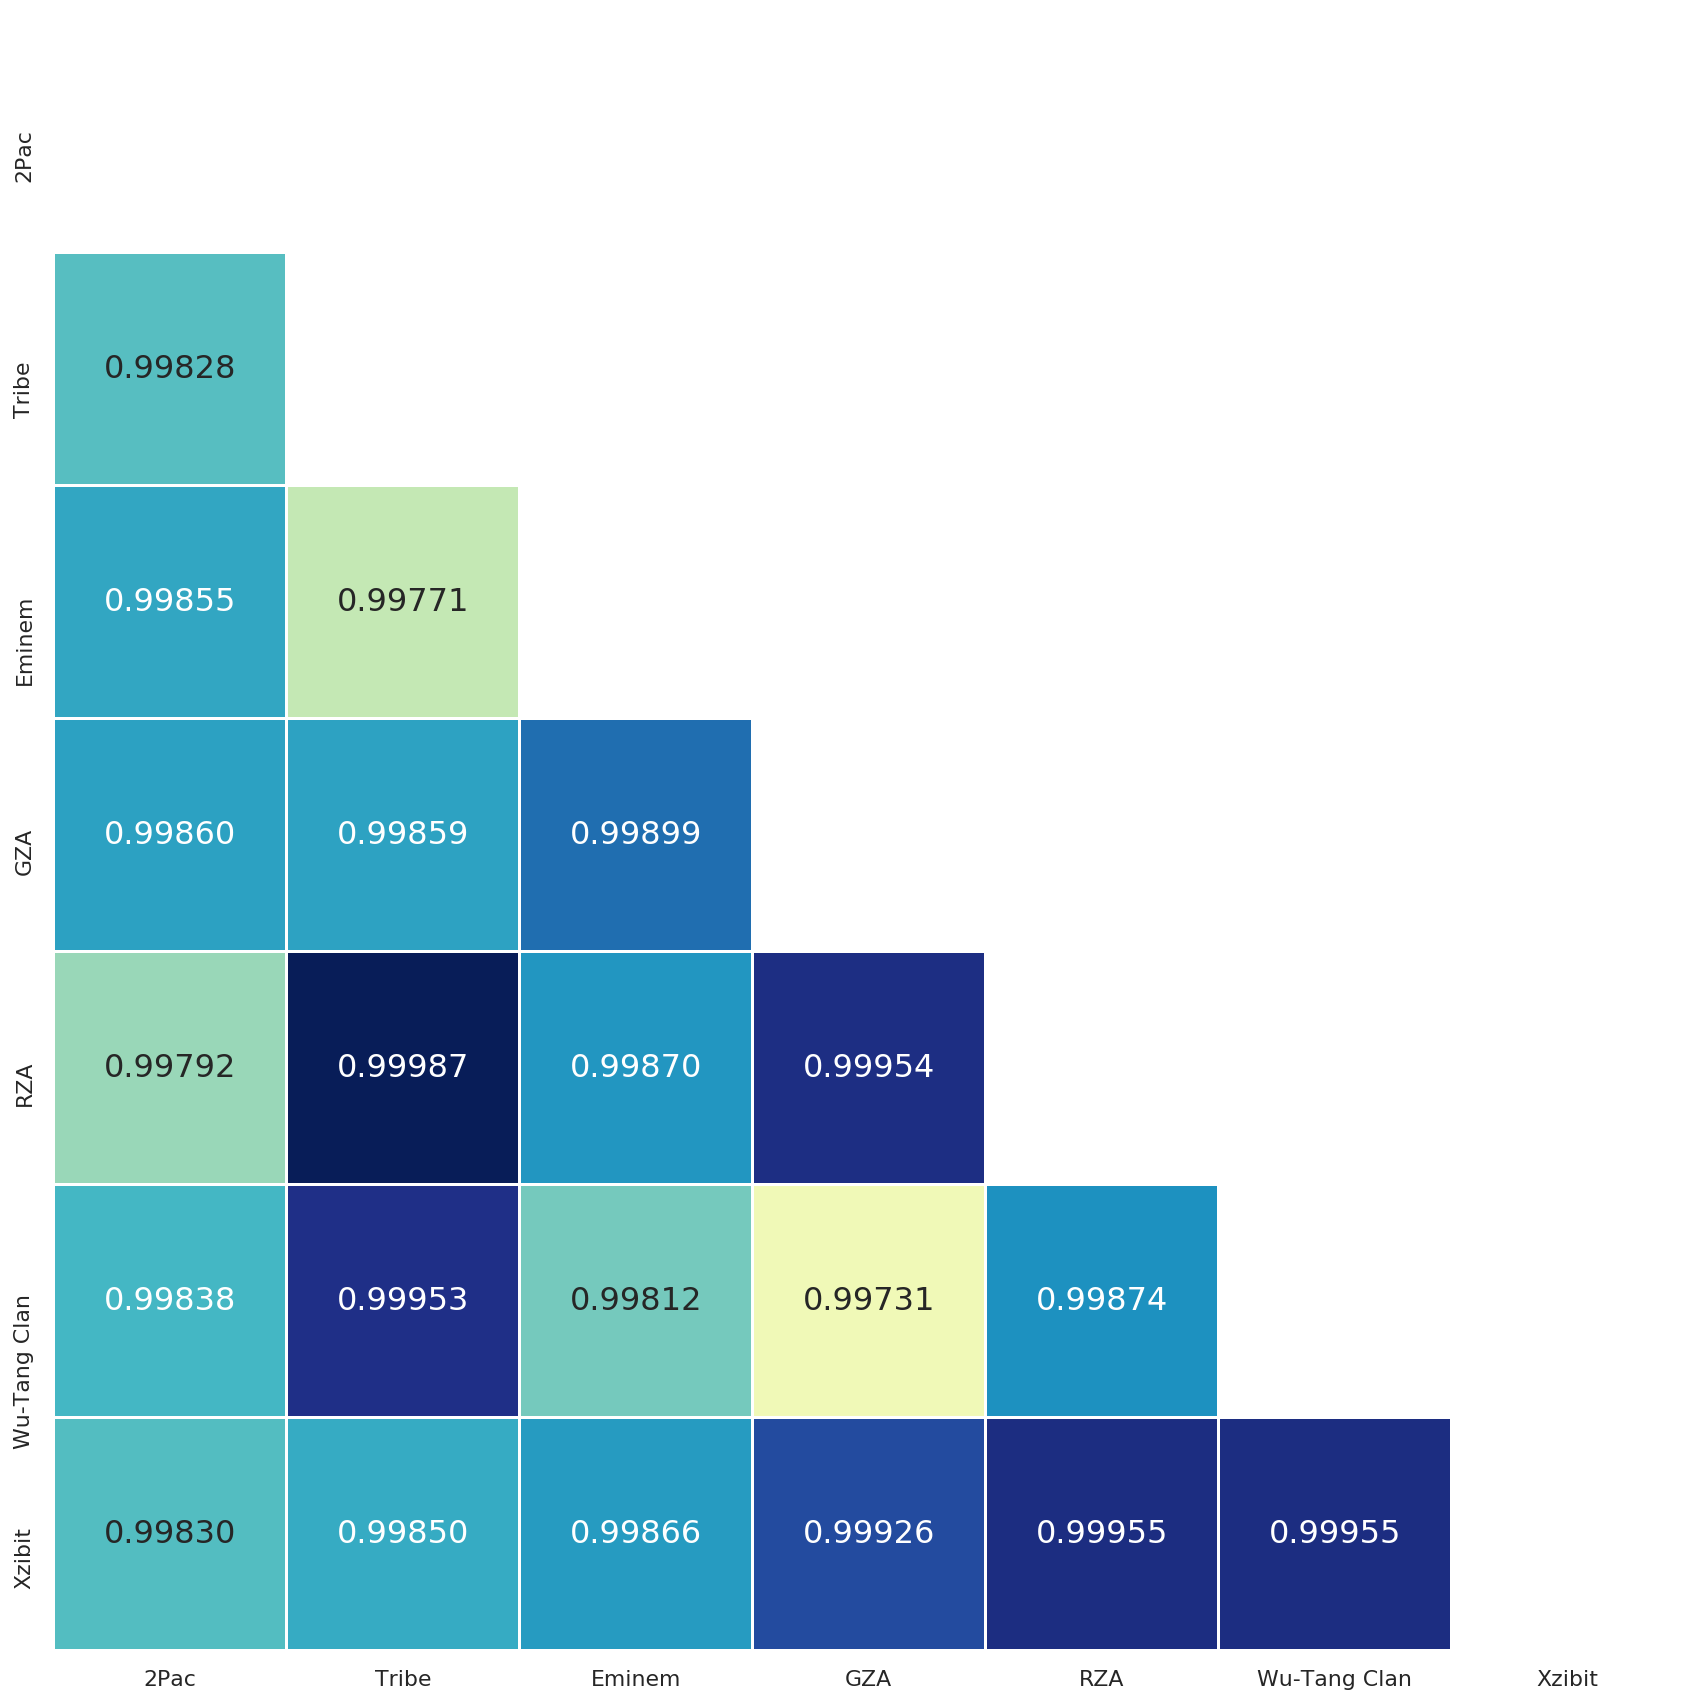

In [42]:
cosine_similarity_subset =DataFrame(cosine_similarity_subset)
cosine_similarity_subset.columns = ["2Pac","Tribe","Eminem","GZA","RZA","Wu-Tang Clan","Xzibit"]
cosine_similarity_subset.index = ["2Pac","Tribe","Eminem","GZA","RZA","Wu-Tang Clan","Xzibit"]

mask = np.zeros_like(cosine_similarity_subset)
mask[np.triu_indices_from(cosine_similarity_subset)] = True

plt.figure(figsize=(15,15))
with sns.axes_style("white"):
    ax = sns.heatmap(cosine_similarity_subset, mask=mask, vmax = 0.9998, vmin = 0.997, square=True,  cmap="YlGnBu", linewidth = 0.8, cbar = False, xticklabels = True, yticklabels = True, annot = True, fmt=".5f", annot_kws={'size':16})
    
    plt.show()

# Run Sparse-SVD dimensionality reduction

Running the SVD-S (Sparse Singular Value Decomposition) algorithm on our wf-idf vectors will choose the most important set of words across all artists, decreasing our dimention of input into the t-SNE algorithm.

In [43]:
# using the scipy.sparse.linalg package import svds

num_components = 50
u, s, v = svds(idf_vectors_matrix, k=num_components)
X = u.dot(np.diag(s))  # output of Sparse SVD

In [44]:
DataFrame(X).head(3)

0         1         2         3         4         5         6   \
0  0.001852 -0.001415 -0.001537  0.002987 -0.003777  0.002052  0.000494   
1  0.000094 -0.000010 -0.000006  0.001069 -0.006532  0.000338  0.000072   
2 -0.000040 -0.000018 -0.000191  0.012203 -0.000580  0.000503  0.000377   

         7         8         9     ...           40        41        42  \
0 -0.002090  0.002631 -0.020431    ...     0.000436 -0.003254  0.004040   
1 -0.000086 -0.000525 -0.000197    ...    -0.001464 -0.000502 -0.000563   
2 -0.000078 -0.000243  0.000021    ...     0.000249 -0.001171  0.000606   

         43        44        45        46        47        48        49  
0  0.012670 -0.000640  0.001301  0.000652 -0.005818 -0.006101 -0.011332  
1  0.001416 -0.000087  0.000055 -0.004174 -0.002225 -0.000631 -0.000995  
2  0.003825 -0.000871  0.000275  0.000002 -0.000391 -0.000758 -0.000925  

[3 rows x 50 columns]

# Export Data for t-SNE Projector

Data for the t-SNE projector (built in tensorflow, http://projector.tensorflow.org/) needs to be in two separate files - one with just the vectors (stripped of index and column names), and the other is the metadata file with artist names.

** Export vectors and metadata FOR ALL HIP HOP ARTISTS **

In [45]:
dh.export_csv(df = DataFrame(X),index = False, header = False, sep='\t', filename = 'wf_idf_svds_vectors.txt')

Copy To Clipboard 
 Download 
 wf_idf_svds_vectors.txt

In [46]:
dh.export_csv(df = DataFrame(idf_vectors_matrix.index.get_values()),sep='\t', index = False, header = False, filename = 'wf_idf_svds_metadata.txt')

Copy To Clipboard 
 Download 
 wf_idf_svds_metadata.txt

# Sample outputs from T-SNE projector

The T-SNE projector has a few user-input levers and a few dynamically adjusted inputs.  This means that re-running the same algorithm with the same input may result in visually different 2- and 3-d graphs.  Below are some sample graphs that I found worked particularly well  

** 2-d algorithm graph **

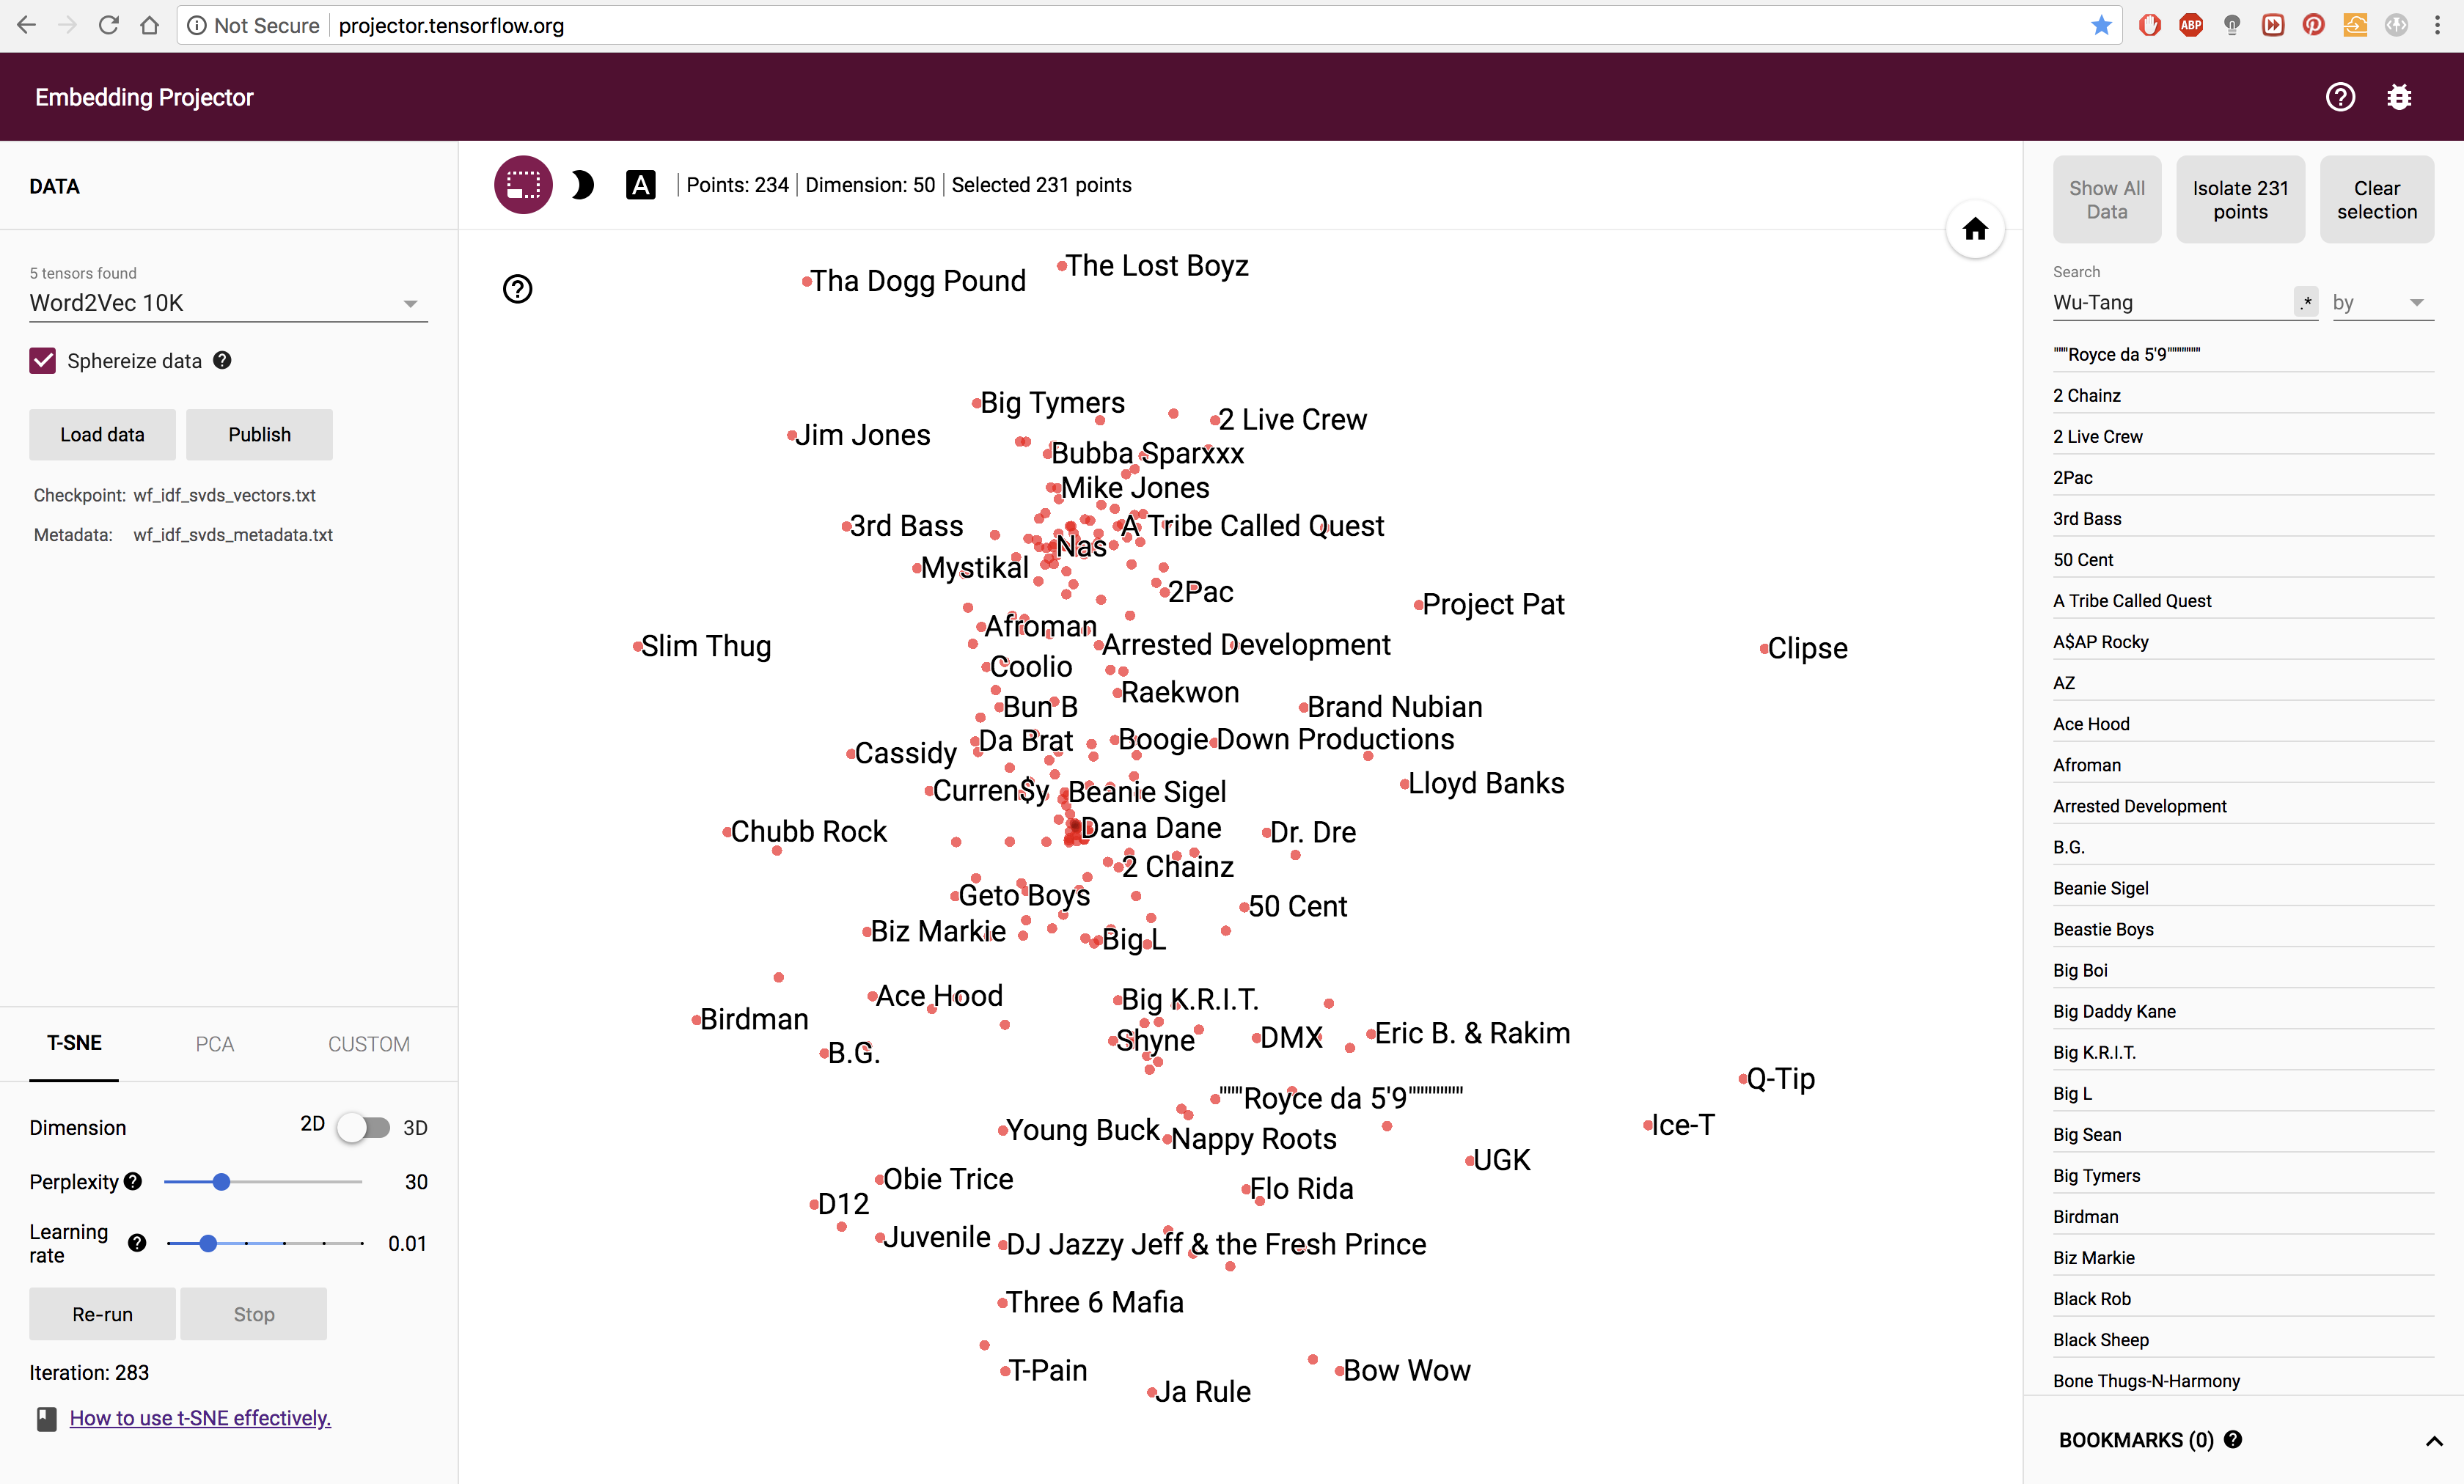

In [26]:
# from IPython.display import Image
Image(filename="/home/prod/jupyter_notebooks/notebooks/Users/rafalnowak/Hip Hop Kaggle/final_graph_2d_all_points.png")

** 3-d graph **

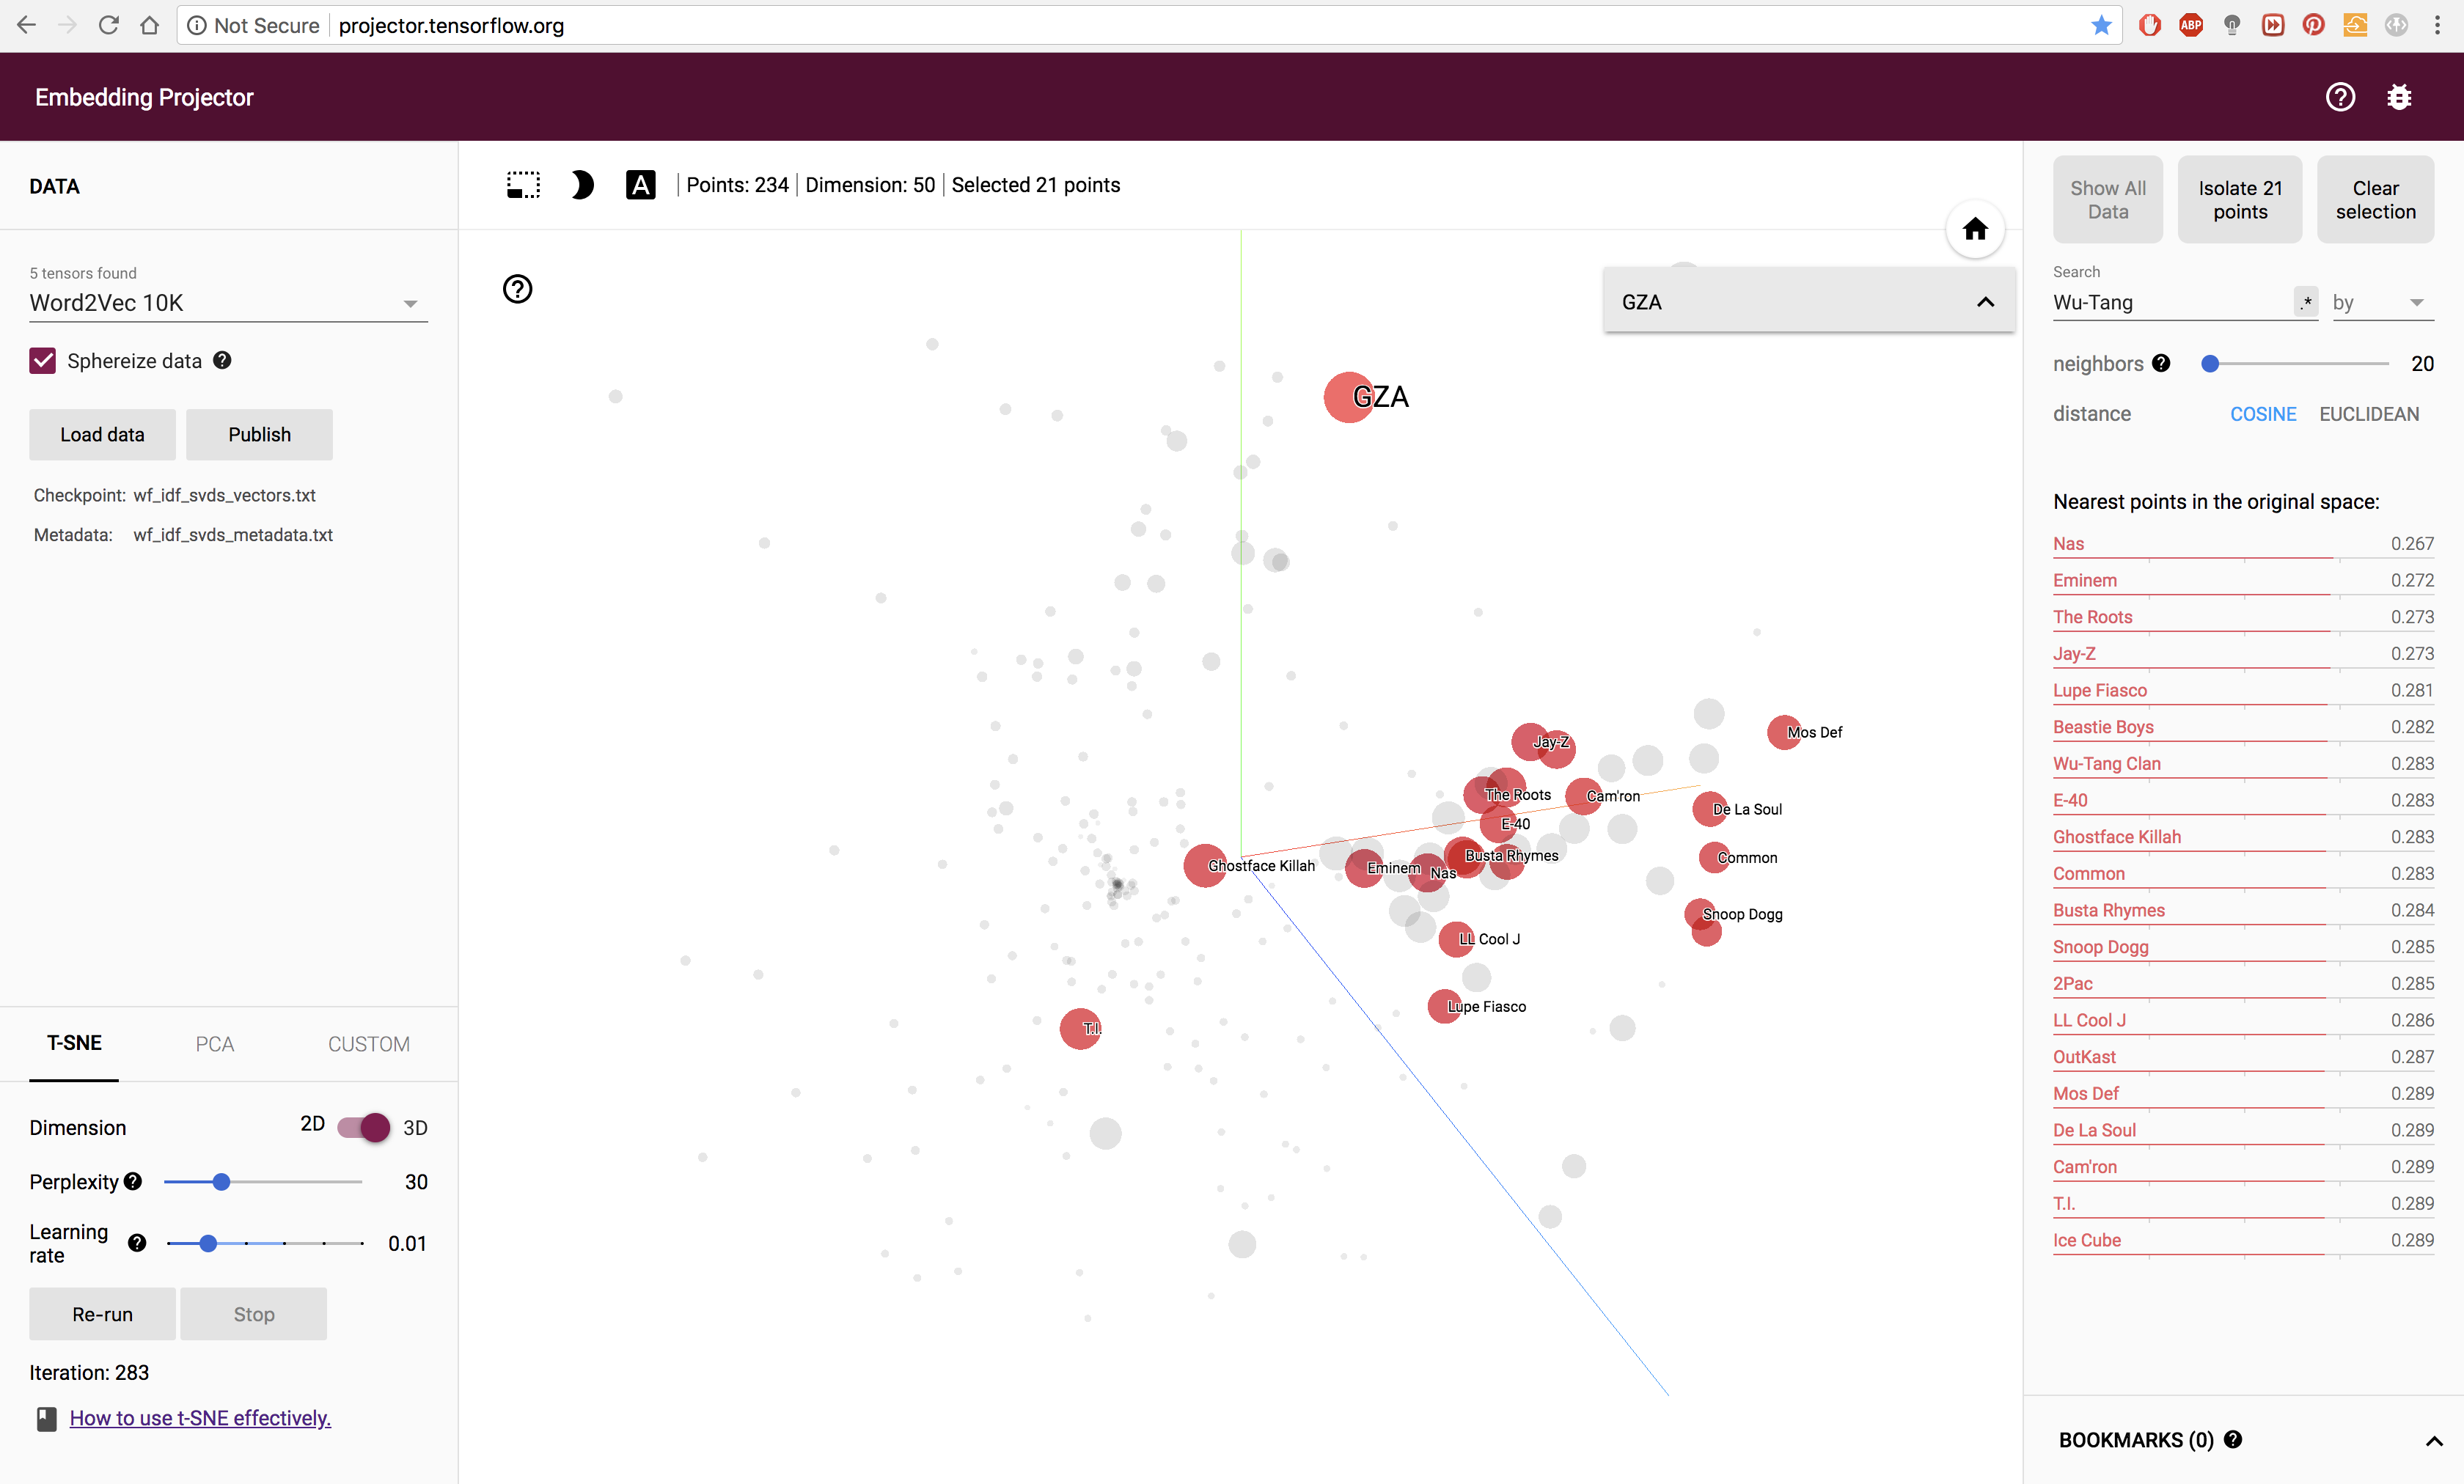

In [27]:
Image(filename="/home/prod/jupyter_notebooks/notebooks/Users/rafalnowak/Hip Hop Kaggle/final graph 3d.png")

** closeup of 3-d graph **

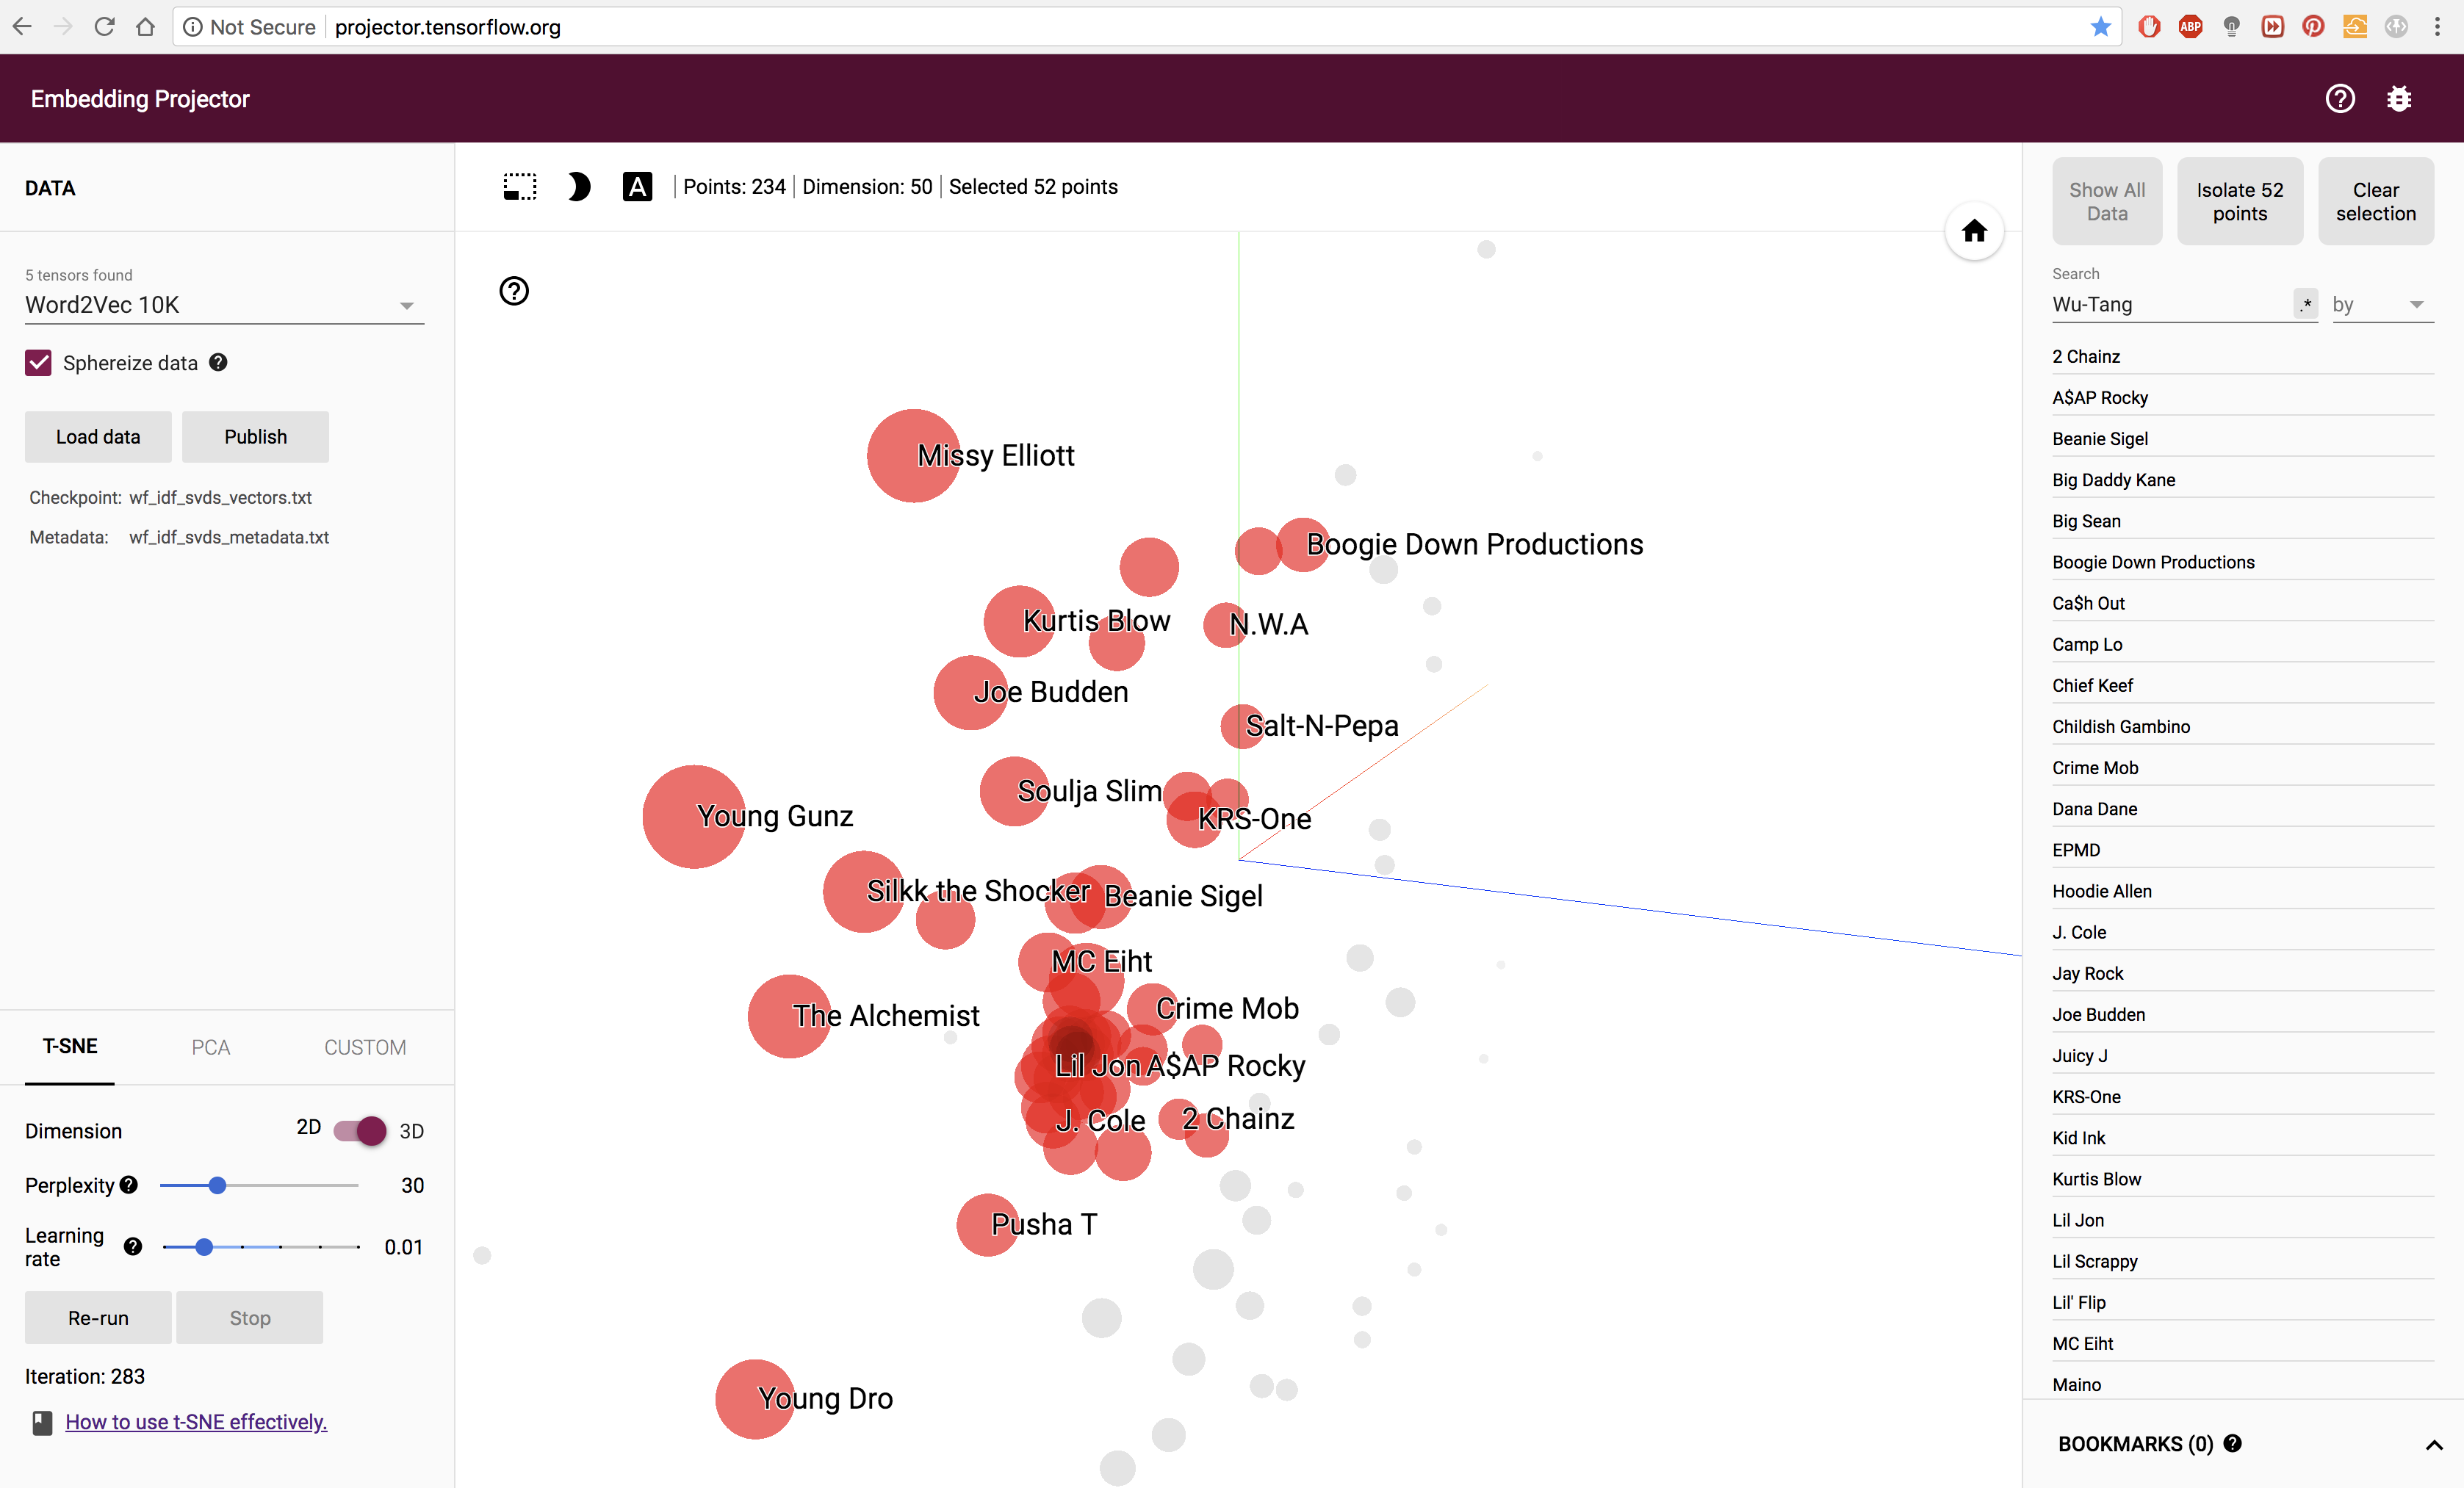

In [28]:
Image(filename="/home/prod/jupyter_notebooks/notebooks/Users/rafalnowak/Hip Hop Kaggle/final_graph_3d_other_points_zoom.png")

**_Fin!_**